<a href="https://colab.research.google.com/github/datasith/ML-Notebooks-TensorFlow/blob/main/Image_Similarity_Siamese_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Similarity using Siamese Networks

In this notebook I provide a short introduction and overview of the process involved in building a **Convolutional Neural Network** (CNN) in **TensorFlow** using the **Siamese Network** architecture. This follows the fantastic **PyTorch** equivalent written by [Elvis Saravia](https://github.com/dair-ai/ML-Notebooks) et al.

---
**Author:** Cisco Zabala ([@datasith](https://twitter.com/datasith) | [LinkedIn](https://www.linkedin.com/in/datasith/) | [Kaggle](https://kaggle.com/thedatasith) | [GitHub](https://github.com/datasith))

*Based on the work by Elvis Saravia ([Twitter](https://twitter.com/omarsar0) | [LinkedIn](https://www.linkedin.com/in/omarsar/)) on GitHub: [ML Notebooks](https://github.com/dair-ai/ML-Notebooks)*

## Background

The Siamese Neural Network (sometimes called a twin neural network), proposed for [the first time in \*1993\*](https://proceedings.neurips.cc/paper/1993/file/288cc0ff022877bd3df94bc9360b9c5d-Paper.pdf), is an artificial neural network comprised by two identical Convolutional subnetworks, each of which uses the same weights while working in tandem on two different input vectors to compute output vectors.

[<img src="https://raw.github.com/datasith/ML-Notebooks-TensorFlow/main/img/Image_Similarity_Siamese_Network/siamese-nn.png" width="600"/>](https://raw.github.com/datasith/ML-Notebooks-TensorFlow/main/img/Image_Similarity_Siamese_Network/siamese-nn.png)

*Source: [SigNet article](https://arxiv.org/pdf/1707.02131.pdf)*

As the weights are shared, two extremely similar images can not possibly be mapped by their respective networks to very different locations in feature space as each network computes the same function.

Given that the mapping of two similar input images to feature space results in the observations being in close proximity, the network can be exposed to pairs of similar and dissimilar images and the weights can be trained to minimize a similarity metric (e.g., Euclidean distance, cosine) between similar pairs while simultaneously maximizing it between dissimilar pairs.

Popular applications of Siamese networks include:
* One-shot learning: classification under the restriction that we may only observe a single example of each possible class
* Offline signature verification
* Facial recognition

References:

* [Bromley et al., 1993](https://proceedings.neurips.cc/paper/1993/file/288cc0ff022877bd3df94bc9360b9c5d-Paper.pdf)
* [Fei-Fei et al., 2006](http://vision.stanford.edu/documents/Fei-FeiFergusPerona2006.pdf)

## Importing the libraries

Like with any other programming exercise, the first step is to import the necessary libraries. As we are going to be using Google Colab to program our Siamese Neural Network, we need to install and import the necessary TensorFlow libraries.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import seaborn as sns
import tensorflow as tf

# from pca_plotter import PCAPlotter
from tensorflow.keras.datasets import mnist, fashion_mnist
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import layers, utils, callbacks
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
# print out the tensorflow version used
print(tf.__version__)

# print out any available GPU devices
print(tf.config.list_physical_devices('GPU'))

2.8.2
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Loading the data: Fashion-MNIST dataset

**Fashion-MNIST** is a dataset of article images (from Zalando) consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes. Zalando intends Fashion-MNIST to serve as a direct drop-in replacement for the original MNIST dataset for benchmarking machine learning algorithms. It shares the same image size and structure of training and testing splits.

It's a perfect dataset for the purpose of our case study, and it's readily available through the `tensorflow.keras.datasets` API:

In [ ]:
# Load the images and labels from the dataset API
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

# Normalize the pixel data
X_train = 1 - (X_train / 255.0)
X_test  = 1 - (X_test / 255.0)

# Add batch size channel for working in TensorFlow
X_train = np.expand_dims(X_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)

# As a sanity check, print the dimensions of data and labels, as well as the
# total number of classes
print(X_train.shape, y_train.shape, len(np.unique(y_train)))

(60000, 28, 28, 1) (60000,) 10


## Generate positive and negative image pairs

In order to train our Siamese Neural Network, we need to provide it with two kinds of image pairs. The two kinds are term "positive" and "negative". A "positive" pair contains an "anchor" image and a second one from the same class, whereas a "negative" pair contains the "anchor" image and a second one from \*any\* other class.

[<img src="https://raw.github.com/datasith/ML-Notebooks-TensorFlow/main/img/Image_Similarity_Siamese_Network/triplet-loss.png" width="600"/>](https://raw.github.com/datasith/ML-Notebooks-TensorFlow/main/img/Image_Similarity_Siamese_Network/triplet-loss.png)
*Source: [Triplet loss and online triplet mining](https://omoindrot.github.io/triplet-loss) (2018)*

How we choose these pairs, and thus construct our testing and training datasets, will impact the performance of our model. There are "offline" and "online" strategies that describe whether we construct the pairs prior to or during training. This becomes more relevant in the context of `Triplet Mining` and `Triplet Neural Networks`, a close *relative* to the Siamese ones we are using. For a nice overview of the the "offline" vs. "online" approaches, please visit:

- [Olivier Moindrot's blog](https://omoindrot.github.io/triplet-loss)

In [ ]:
def make_pairs(images, labels, seed=42):
    # Use seed parameter for consistency of results
    np.random.seed(seed)

    # Define variables we'll use for generating image pairs
    pair_images = []
    pair_labels = []
    num_classes = len(np.unique(labels))

    # Generate a list of np.arrays, where each np.array in the list contains
    # the indexes for input images belonging to the class corresponding to the
    # index of the np.array in the list
    # e.g.:
    # the first item in the list (at index 0) will contain all the indexes of 
    # input images whose label/class is 0.
    indexes = [np.where(labels == i)[0] for i in range(num_classes)]

    # Iterate through each input image and create a positive and negative pair
    for idx_a in range(len(images)):
        anchor_img = images[idx_a]
        label = labels[idx_a]

        # Ensure that the positive pair doesn't consist of repeated images
        idx_p = idx_a
        while idx_p == idx_a:
          idx_p = np.random.choice(indexes[label])

        positive_img = images[idx_p]
        # Add the positive image pair to our output
        pair_images.append([anchor_img, positive_img])
        # Label positive image pairs as "1" (arbitrary choice)
        pair_labels.append([1])

        # For a negative pair simply select any image that doesn't belong to the
        # anchor image's class
        idx_n = np.where(labels != label)[0]
        negative_img = images[np.random.choice(idx_n)]
        
        # Add the negative image pair to our output
        pair_images.append([anchor_img, negative_img])
        # Label negative image pairs as "0" (arbitrary choice)
        pair_labels.append([0])
    
    pair_images, pair_labels = np.array(pair_images), np.array(pair_labels)
    
    # # Make sure we shuffle the data before outputting
    # new_idx = np.random.permutation(len(pair_images))
    # pair_images, pair_labels = pair_images[new_idx], pair_labels[new_idx]

    return (pair_images, pair_labels)

Using the image-pair generation function we defined above, put it to use with the **Fashion-MNIST** data. Using the cell magic utility `%%time` we can see how long the process takes (this can be optimized if needed).

In [ ]:
%%time
# Use our previously defined function to generate positive and negative pairs 
# out of the image data
(pairs_train, labels_train) = make_pairs(X_train, y_train)
(pairs_test, labels_test) = make_pairs(X_test, y_test)

# As a sanity check, print the dimensions of image pairs — they should be 
# 2X of the original data (60,000 and 10,000) as we're generating two pairs per
# input image
print(f'Train Data Shape: {pairs_train.shape}')
print(f'Test  Data Shape: {pairs_test.shape}')

Train Data Shape: (120000, 2, 28, 28, 1)
Test  Data Shape: (20000, 2, 28, 28, 1)
CPU times: user 12.2 s, sys: 385 ms, total: 12.6 s
Wall time: 12.6 s


Now, to verify that the data is what we expect, let's visualize a few of the positive and negative image pairs:

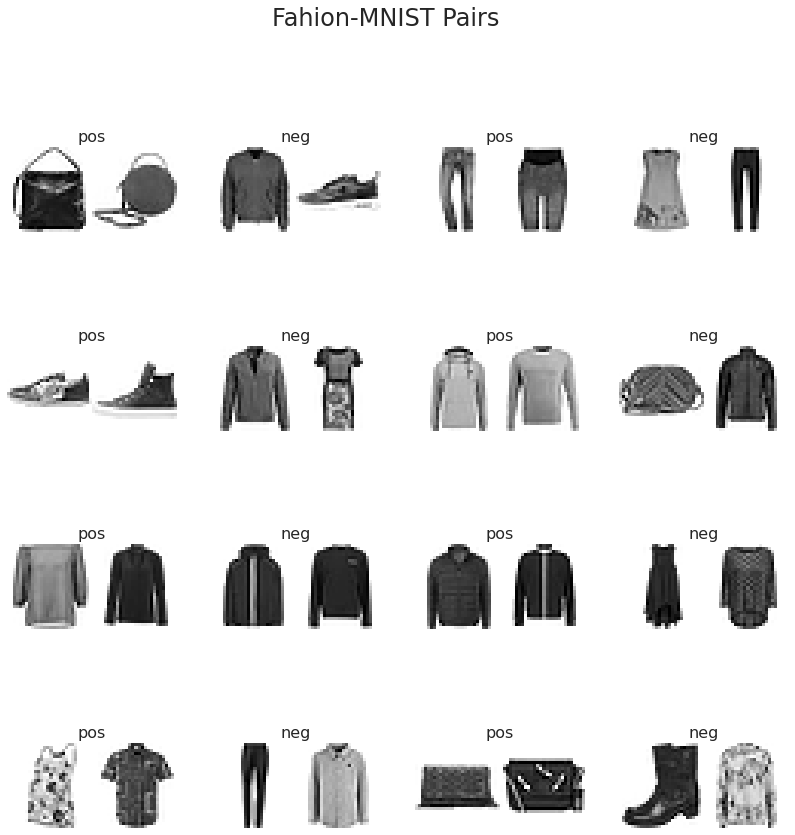

In [ ]:
# Create a 4x4 figure which will alternate between similar and different pairs
# of images
sns.set_style('white')

fig, ax = plt.subplots(4, 4, figsize=(12, 12))
random.seed(42)

indexes_pos = np.where(labels_train == 1)[0]
indexes_neg = np.where(labels_train == 0)[0]

indexes_pos = random.choices(indexes_pos, k=8)
indexes_neg = random.choices(indexes_neg, k=8)

subtitles = ["pos", "neg"]

for i in range(0,16,2):
    i_pos = indexes_pos[i//2]
    img1_pos, img2_pos = pairs_train[i_pos]
    img1_pos, img2_pos = np.squeeze(img1_pos), np.squeeze(img2_pos)
    img_pos = np.hstack([img1_pos, img2_pos])

    # print(i//2, i//4, i%4)

    ax[i//4][i%4].imshow(img_pos, cmap='gray')
    ax[i//4][i%4].set_title(f"{subtitles[i%2]}", fontsize=16)
    ax[i//4][i%4].set_axis_off()
    i_neg = indexes_neg[i//2]

    img1_neg, img2_neg = pairs_train[i_neg]
    img1_neg, img2_neg = np.squeeze(img1_neg), np.squeeze(img2_neg)
    img_neg = np.hstack([img1_neg, img2_neg])

    ax[i//4][i%4+1].imshow(img_neg, cmap='gray')
    ax[i//4][i%4+1].set_title(f"{subtitles[~i%2]}", fontsize=16)
    ax[i//4][i%4+1].set_axis_off()
    
fig.suptitle('Fahion-MNIST Pairs', fontsize=24);

## Build a Siamese model

To measure how similar (or dissimilar) two images are, a Siamese Network extracts a feature vector from each image and uses a metric to determine whether those features are "close" or not. As it's typical, we use distance or the cosine of the angle to determine "closeness". In this specific case, we implement both and compare the performance at the end.

In [ ]:
def euclidean_distance(features):
    (feat1, feat2) = features
    ssr = tf.keras.backend.sum(tf.keras.backend.square(feat1 - feat2), axis=1, keepdims=True)
    return tf.keras.backend.sqrt(tf.keras.backend.maximum(ssr, tf.keras.backend.epsilon()))

def cosine_distance(features):
    (feat1, feat2) = features
    feat1 = tf.keras.backend.l2_normalize(feat1)
    feat2 = tf.keras.backend.l2_normalize(feat2)
    return tf.keras.backend.batch_dot(feat1, feat2)

feat1 = np.random.rand(64,1)
feat2 = np.random.rand(64,1)
feat1 = tf.keras.backend.l2_normalize(feat1)

assert tf.norm(feat1, ord=2) == np.array([1])
assert euclidean_distance([feat1,feat2]).shape == cosine_distance([feat1,feat2]).shape

Once we have a measure of closeness, we can make use of it as part of the our network's forward pass output. This output is what we use to compute an objective function, which typically consists of a loss function that we attempt to minimize. In the case of Siamese netowks, the two most commonly used are:
* [Contrastive loss](https://en.everybodywiki.com/index.php?title=Siamese_networks)
* [Triplet loss](https://en.everybodywiki.com/index.php?title=Siamese_networks)

The contrastive loss function is formulated by considering two training examples $\mathbf {x} _{i}$ and $\displaystyle \mathbf {x} _{j}$ along with their labels $\displaystyle y_{i}$ and $\displaystyle y_{j}$. Given a positive scalar value $\displaystyle t$ (squared _margin_) the contrastive loss is:

$$
\mathcal{L}_{\text{cnt}} = \mathbf{1}[y_i=y_j]\lVert f_{\theta}(\mathbf{x}_i)-f_{\theta}(\mathbf{x}_j)\rVert^2 + \mathbf{1}[y_i\neq y_j] \max(0, t-\lVert f_{\theta}(\mathbf{x}_i)-f_{\theta}(\mathbf{x}_j)\rVert^2)
$$

where $\mathbf {1} [\cdot ]$ denotes the indicator function and 
$\lVert \cdot \rVert$ denotes the Euclidean distance. The 
$\max(0,\cdot )$ operator is used to lower bound the loss when 
$y_{i}\neq y_{j}$. Intuitively, minimizing $\displaystyle {\mathcal {L}}_{\text{cnt}}$ forces $\displaystyle f_{\theta }(\mathbf {x} _{i})$ and $\displaystyle f_{\theta }(\mathbf {x} _{j})$ vectors to be closer to each other when $y_{i}=y_{j}$, and to separate by a distance of ${\sqrt {t}}$ when $\displaystyle y_{i}\neq y_{j}$. Thus, reflecting the semantic similarity of raw data in the transformed domain.

**_Source: https://en.everybodywiki.com/index.php?title=Siamese_networks_**

In [ ]:
# Implementing the contrastive loss function means that for all x_i image inputs 
# we calculate:
#
# Contrastive loss = mean( (1-true_value) * square(prediction) + 
#                          true_value * square( max(margin - prediction, 0)))
#
# where the indicator function is given by whether the image pair constitutes
# a positive sample (y_i = y_j) or negative (y_i ≠ y_j).
def loss(margin=1):
    def contrastive_loss(y_true, y_pred):
        y_true = tf.cast(y_true, y_pred.dtype)
        square_pred = tf.math.square(y_pred)
        margin_square = tf.math.square(tf.math.maximum(margin - (y_pred), 0))
        return tf.math.reduce_mean(
            (1 - y_true) * square_pred + (y_true) * margin_square
        )

    return contrastive_loss

With our loss function in place, we can define our model considering the following:

* The model contains two input layers
* The model conatins a CNN-based feature extractor that generates feature vectors for both image inputs
* The feature vectors are passed through a custom layer to get their similarity score (euclidean or cosine distance)
* The similarity score is passed through a `relu` activation function and the output is used to compute the loss value

In [ ]:
# Before training, we set up a few configuration parameters
class config():
    IMG_SHAPE = (28, 28, 1)
    EMBEDDING_DIM = 128
    BATCH_SIZE = 128
    EPOCHS = 100

# We can also set up initialization functions for our model paremeters, although 
# our defaults are usually the best choice — see commented out code in the model 
# definition for more details
def initialize_weights(shape, dtype=tf.float32, name=None):
    """
        The paper, http://www.cs.utoronto.ca/~gkoch/files/msc-thesis.pdf
        suggests to initialize CNN layer weights with mean as 0.0 and standard deviation of 0.01
    """
    return np.random.normal(loc = 0.0, scale = 2e-2, size = shape)

def initialize_bias(shape, dtype=tf.float32, name=None):
    """
        The paper, http://www.cs.utoronto.ca/~gkoch/files/msc-thesis.pdf
        suggests to initialize CNN layer bias with mean as 0.5 and standard deviation of 0.01
    """
    return np.random.normal(loc = 0.5, scale = 2e-2, size = shape)    

Different approaches can be taken to define our Siamese model. We define a single "Feature Extractor" network, and we pass both input images through it. Then we use the feature vectors for subsequent computations:

In [ ]:
class SiameseNetwork(Model):
    def __init__(self, inputShape, embeddingDim):
        super(SiameseNetwork, self).__init__()
        
        imgA = layers.Input(shape=inputShape)
        imgB = layers.Input(shape=inputShape)
        featureExtractor = self.build_feature_extractor(inputShape, embeddingDim)
        featsA = featureExtractor(imgA)
        featsB = featureExtractor(imgB)
        distance = layers.Lambda(cosine_distance, name='cosine_distance')([featsA, featsB])
        outputs = layers.Dense(1, activation="sigmoid")(distance)
        self.model = Model(inputs=[imgA, imgB], outputs=outputs)        
        
    def build_feature_extractor(self, inputShape, embeddingDim=48):

        model = Sequential([
            layers.Input(inputShape),
            layers.Conv2D(64, 2, padding="same", activation="relu"),
            # layers.Conv2D(64, (2, 2), padding="same", activation="relu",
            #               kernel_initializer=initialize_weights,
            #               kernel_regularizer=tf.keras.regularizers.l2(2e-4),
            #               bias_initializer=initialize_bias),
            layers.MaxPooling2D(pool_size=2),
            # layers.Dropout(0.3),
            layers.Conv2D(64, 2, padding="same", activation="relu"),            
            # layers.Conv2D(64, (2, 2), padding="same", activation="relu",
            #               kernel_initializer=initialize_weights,
            #               kernel_regularizer=tf.keras.regularizers.l2(2e-4),
            #               bias_initializer=initialize_bias),
            layers.MaxPooling2D(pool_size=2),
            # layers.Dropout(0.3),
            layers.Conv2D(128, 1, padding="same", activation="relu"),            
            # layers.Conv2D(128, (1, 1), padding="same", activation="relu",
            #               kernel_initializer=initialize_weights,
            #               kernel_regularizer=tf.keras.regularizers.l2(2e-4),
            #               bias_initializer=initialize_bias),
            layers.Flatten(),
            layers.Dense(128, activation='relu')
        ])

        return model  
        
    def call(self, x):
        return self.model(x)

es = callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=1, 
    restore_best_weights=True, min_delta=1e-4)

rlp = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, 
    min_lr=1e-6, mode='min', verbose=1)

After defining standard training-loop functions, we're ready to build our model:

In [ ]:
if 'model' in globals():
    del model

model = SiameseNetwork(
    inputShape=config.IMG_SHAPE,
    embeddingDim=config.EMBEDDING_DIM
)
model.compile(
    loss=loss(margin=1),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), 
    metrics=["accuracy"]
)

It's always a good sanity check to visualize our model and compare it to our expectations:

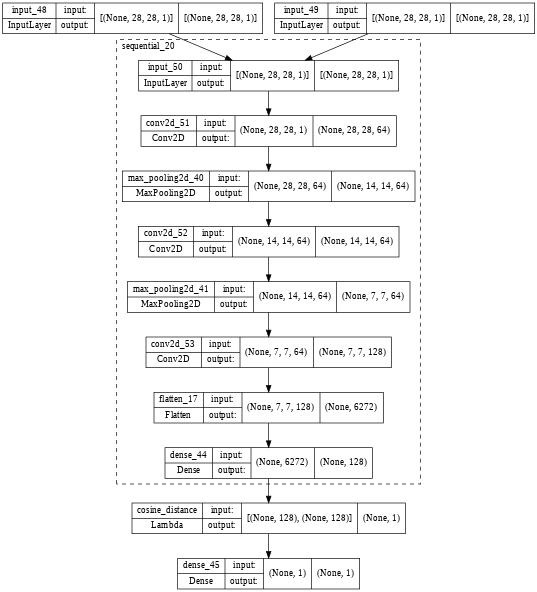

In [ ]:
utils.plot_model(model.model, show_shapes=True, expand_nested=True, dpi=48)

Once we have all the pieces in place, it's time to actually train the model:

In [ ]:
history = model.fit(
    [pairs_train[:, 0], pairs_train[:, 1]], labels_train[:],
    validation_data=([pairs_test[:, 0], pairs_test[:, 1]], labels_test[:]),
    batch_size=config.BATCH_SIZE, 
    epochs=config.EPOCHS,
    callbacks=[es, rlp]
)

Epoch 1/100
938/938 [==============================] - 8s 8ms/step - loss: 0.2354 - accuracy: 0.5772 - val_loss: 0.2354 - val_accuracy: 0.5777 - lr: 0.0100
Epoch 2/100
938/938 [==============================] - 8s 8ms/step - loss: 0.2345 - accuracy: 0.5784 - val_loss: 0.2347 - val_accuracy: 0.5775 - lr: 0.0100
Epoch 3/100
938/938 [==============================] - 7s 8ms/step - loss: 0.2340 - accuracy: 0.5788 - val_loss: 0.2346 - val_accuracy: 0.5775 - lr: 0.0100
Epoch 4/100
938/938 [==============================] - 7s 8ms/step - loss: 0.2336 - accuracy: 0.5793 - val_loss: 0.2343 - val_accuracy: 0.5787 - lr: 0.0100
Epoch 5/100
938/938 [==============================] - 8s 8ms/step - loss: 0.2333 - accuracy: 0.5797 - val_loss: 0.2341 - val_accuracy: 0.5785 - lr: 0.0100
Epoch 6/100
938/938 [==============================] - 8s 8ms/step - loss: 0.2331 - accuracy: 0.5806 - val_loss: 0.2339 - val_accuracy: 0.5784 - lr: 0.0100
Epoch 7/100
938/938 [==============================] - 7s 8ms/st

After training, we can finally see the performance of the model with training and validation samples:

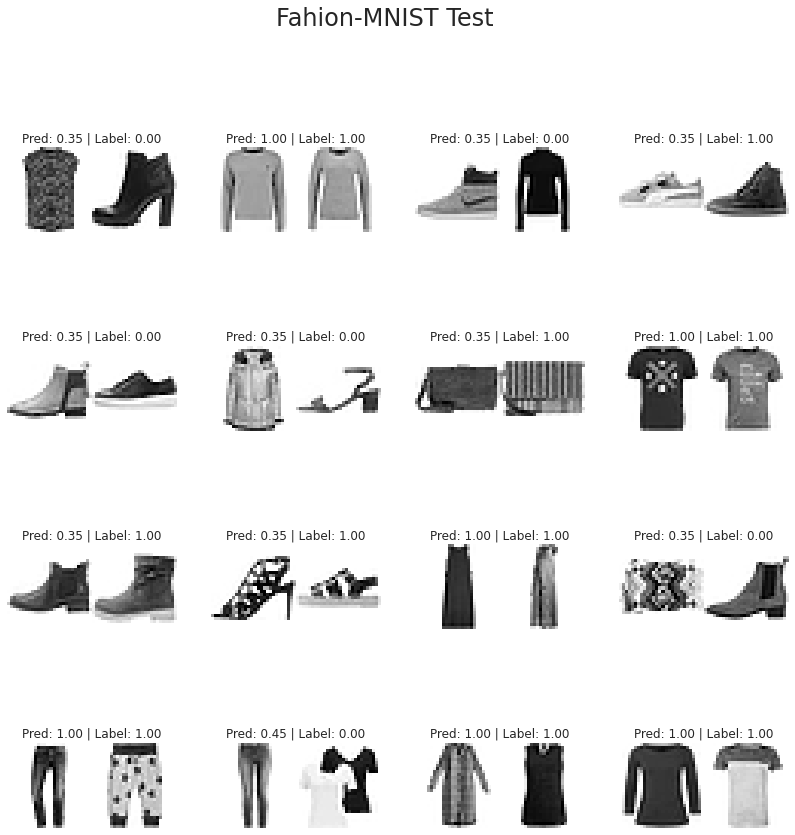

In [ ]:
sns.set_style('white')
fig, ax = plt.subplots(4, 4, figsize=(12, 12))

indexes = random.choices(range(len(pairs_test)), k=16)
preds = model.predict([pairs_test[indexes, 0], pairs_test[indexes, 1]])
labels = labels_test[indexes]

for i in range(16):
    idx = indexes[i]
    img1_test, img2_test = pairs_test[idx]
    img1_test, img2_test = np.squeeze(img1_test), np.squeeze(img2_test)
    img_test = np.hstack([img1_test, img2_test])

    score = preds[i].item()
    label = labels[i].item()

    ax[i//4][i%4].imshow(img_test, cmap='gray')
    ax[i//4][i%4].set_title(f"Pred: {score:.2f} | Label: {label:.2f}", fontsize=12)
    ax[i//4][i%4].set_axis_off()
    
fig.suptitle('Fahion-MNIST Test', fontsize=24);

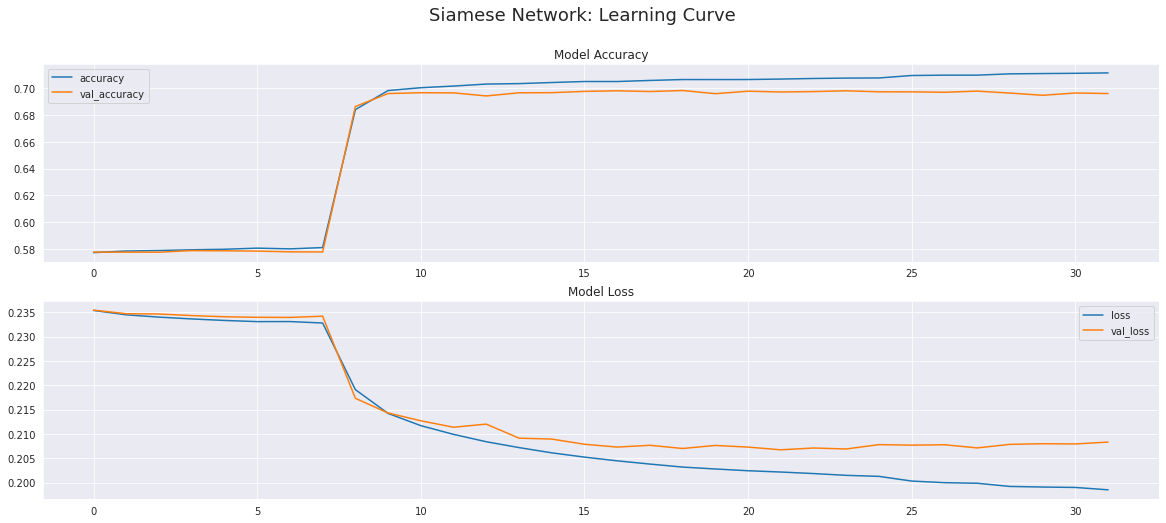

In [ ]:
sns.set_style('darkgrid')

fig, ax = plt.subplots(2, 1, figsize=(20, 8))
df = pd.DataFrame(history.history)
df[['accuracy', 'val_accuracy']].plot(ax=ax[0])
df[['loss', 'val_loss']].plot(ax=ax[1])
ax[0].set_title('Model Accuracy', fontsize=12)
ax[1].set_title('Model Loss', fontsize=12)
fig.suptitle('Siamese Network: Learning Curve', fontsize=18);

# References
- [Fisher Discriminant Triplet and Contrastive Losses for Training Siamese Networks](https://arxiv.org/pdf/2004.04674v1.pdf)